# Projet 5: Catégorisez automatiquement des questions

## Partie 1: Nettoyage et Exploration des données

In [1]:
#importation des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from wordcloud import WordCloud

#Traitement des données
from bs4 import BeautifulSoup #extraction du texte
import string
import re #regex
import nltk #traitement du texte
nltk.download('punkt')
nltk.tokenize.word_tokenize #tokenization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
nltk.download('stopwords')
from nltk.corpus import stopwords #stop words
stop_words = stopwords.words('english') 
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer #lemmatisation
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer #stemming porter
porter = PorterStemmer()
from nltk.stem import LancasterStemmer #stemming lancaster
lancaster=LancasterStemmer()

#importation des librairies - visualisation
from sklearn.feature_extraction.text import CountVectorizer
import collections

from sklearn.model_selection import train_test_split

#Normalisation des données
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Exploration du dataset
Le dataset a été récupéré sur le site "stackexchange explorer" qui permet d'exporter des données sur le site stackoverflow. Le chargement a été fait en plusieurs requêtes SQL, étant donné que le site borne à 50 000 entrées.

In [2]:
#importation du dataset

In [3]:
df = pd.read_csv('data3.csv')

In [4]:
df.dtypes

OwnerUserId     int64
Body           object
Tags           object
Title          object
dtype: object

In [5]:
df.shape

(50000, 4)

In [6]:
df.head()

,OwnerUserId,Body,Tags,Title
0,5,"<p>The MSDN library <a href=""http://msdn.micro...",<c#><async-await><c#-5.0>,Why is the C# 5.0 await keyword listed as an o...
1,4,"<p>When Mercurial is running under cygwin, it'...",<mercurial><merge><cygwin><winmerge>,How can I configure Mercurial to use WinMerge ...
2,5,<p>I generally use a manual process:</p>\n\n<o...,<html><css>,What's the best way to go from a Photoshop moc...
3,4,"<p>How do I move the <a href=""http://en.wikipe...",<logo-lang>,How do I move the turtle in LOGO?
4,4,<p>I'm building the world's simplest library a...,<api><language-agnostic><amazon><barcode>,How can I lookup data about a book from its ba...


In [7]:
df = df.drop('OwnerUserId', axis = 1)

In [8]:
df.iloc[4,:]

Body     <p>I'm building the world's simplest library a...
Tags             <api><language-agnostic><amazon><barcode>
Title    How can I lookup data about a book from its ba...
Name: 4, dtype: object

## 2. Préparation du Texte

### 2.1 Obtenir le texte
Le premier travail est de parvenir à sortir le texte, sans balise html, et sans "bruit". Le texte est récupéré à partir du Titre et du Body

In [9]:
def totext(x):
    html = x['Body']
    raw = BeautifulSoup(html, "html.parser").get_text()  #Extraction de tout le texte de la structure
    tokens = nltk.tokenize.word_tokenize(raw)
    tokens = [s + " " for s in tokens]
    if (type(x["Title"]) == np.float):
        fullText = (''.join(tokens[:])) #je m'assure que le titre ne soit pas float, auquel cas, il ne rejoint pas ma donnée
    else: 
        fullText = (x["Title"] + " " + ''.join(tokens[:]))
    return fullText

In [10]:
totext(df.loc[0]) # Test avec une ligne

"Why is the C# 5.0 await keyword listed as an operator rather than a modifier? The MSDN library lists the await keyword as an operator . That seems strange to me - I 'd have thought it was a modifier , like the async keyword . Why is this an operator ? "

In [11]:
def totextot(x):
    for i in range (0,len(x)):
        x['Text'].iloc[i] = totext(df.iloc[i])

In [12]:
df['Text'] = df['Body'].copy()

In [13]:
totextot(df) #On transforme le titre et body avec la fonction précedente dans la colonne "Text"

In [14]:
df.head() #On vérifie la bonne implémentation

,Body,Tags,Title,Text
0,"<p>The MSDN library <a href=""http://msdn.micro...",<c#><async-await><c#-5.0>,Why is the C# 5.0 await keyword listed as an o...,Why is the C# 5.0 await keyword listed as an o...
1,"<p>When Mercurial is running under cygwin, it'...",<mercurial><merge><cygwin><winmerge>,How can I configure Mercurial to use WinMerge ...,How can I configure Mercurial to use WinMerge ...
2,<p>I generally use a manual process:</p>\n\n<o...,<html><css>,What's the best way to go from a Photoshop moc...,What's the best way to go from a Photoshop moc...
3,"<p>How do I move the <a href=""http://en.wikipe...",<logo-lang>,How do I move the turtle in LOGO?,How do I move the turtle in LOGO? How do I mov...
4,<p>I'm building the world's simplest library a...,<api><language-agnostic><amazon><barcode>,How can I lookup data about a book from its ba...,How can I lookup data about a book from its ba...


### 2.2 Se séparer de la ponctuation, des stopwords, et des majuscules
La démarche est premièrement de séparer de la ponctuation. Il arrive pourtant que certains cacartères de ponctuation soient importants à conserver, comme le "#" dans "c#". 

In [15]:
mots = ['does', 'nt', 'look', 'looks', 'work', 've', 'try', 'tried', 'got', 'did', 'works', 'div', 'know', 'fine', 'well', 
        'set', 'doing', 'do', 'like', 'using', 'say', 'just', 'need', 'id', 'anyone', 'would', '00', 'could']
stop_words.extend(mots)
#Je rajoute aux stop_words anglais présents dans la base des mots qui reviennent trop et n'apportent pas d'intérêt aux modèles

In [16]:
set(stop_words)

{'00',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'anyone',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'could',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'div',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'fine',
 'for',
 'from',
 'further',
 'got',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'id',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'know',
 'like',
 'll',
 'look',
 'looks',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'nt',
 'o',
 'o

In [17]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = list(stop_words)

def text_prepare(text,join_sumbol):
    """
        text: a string
        
        return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text,)

    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = re.sub(r'\s+'," ",text)

    # delete stopwords from text
    text = f'{join_sumbol}'.join([i for i in text.split() if i not in STOPWORDS])
    
    return text

tests = ["SQL Server - any equivalent of Excel's CHOOSE function?",
        "How to free c++ memory vector<int> * arr?"]
for test in tests: print(text_prepare(test,' '))

sql server equivalent excels choose function
free c++ memory vectorint arr


In [18]:
df['Text'] = [text_prepare(x,' ') for x in df['Text']]

## 3. Travail sur les tags

### 3.1 Étude des tags

In [19]:
df['Tags']

0                            <c#><async-await><c#-5.0>
1                 <mercurial><merge><cygwin><winmerge>
2                                          <html><css>
3                                          <logo-lang>
4            <api><language-agnostic><amazon><barcode>
                             ...                      
49995                                          <swift>
49996                                 <html><css><svg>
49997    <c#><.net><generics><covariance><type-safety>
49998                            <html><xml><comments>
49999                    <winapi><atl><wtl><classname>
Name: Tags, Length: 50000, dtype: object

On note rapidement que les données ne sont pas du tout "propres". Cad que le titre et le body de la question par exemple, sont illisibles car ils contiennent un tas de différentes balises html.

### 3.2 Nettoyage des tags
On cherche d'abord à supprimer les balises pour ensuite pouvoir tokeniser chacun des mots/tags.

#### 3.2.1 Remplacement des balises

In [20]:
_replacements = {
    '<': '',
    '><': ' ',
    '>': ''
}
def _do_replace(match):
    return _replacements.get(match.group(0))

def replace_tags(text, _re=re.compile('|'.join(re.escape(r) for r in _replacements))):
    return _re.sub(_do_replace, text)

In [21]:
df[['Tags']] = df[['Tags']].applymap(replace_tags)

In [22]:
df['Tags']

0                          c# async-await c#-5.0
1                mercurial merge cygwin winmerge
2                                       html css
3                                      logo-lang
4           api language-agnostic amazon barcode
                          ...                   
49995                                      swift
49996                               html css svg
49997    c# .net generics covariance type-safety
49998                          html xml comments
49999                   winapi atl wtl classname
Name: Tags, Length: 50000, dtype: object

#### 3.2.2 Tokenisation des tags

In [23]:
from nltk.tokenize import WhitespaceTokenizer
df['TagsTokens'] = df.apply(lambda x: WhitespaceTokenizer().tokenize(x['Tags']),axis=1)

In [24]:
df.head()

,Body,Tags,Title,Text,TagsTokens
0,"<p>The MSDN library <a href=""http://msdn.micro...",c# async-await c#-5.0,Why is the C# 5.0 await keyword listed as an o...,c# 50 await keyword listed operator rather mod...,"[c#, async-await, c#-5.0]"
1,"<p>When Mercurial is running under cygwin, it'...",mercurial merge cygwin winmerge,How can I configure Mercurial to use WinMerge ...,configure mercurial use winmerge merges cygwin...,"[mercurial, merge, cygwin, winmerge]"
2,<p>I generally use a manual process:</p>\n\n<o...,html css,What's the best way to go from a Photoshop moc...,whats best way go photoshop mockup semantic ht...,"[html, css]"
3,"<p>How do I move the <a href=""http://en.wikipe...",logo-lang,How do I move the turtle in LOGO?,move turtle logo move turtle logo,[logo-lang]
4,<p>I'm building the world's simplest library a...,api language-agnostic amazon barcode,How can I lookup data about a book from its ba...,lookup data book barcode number building world...,"[api, language-agnostic, amazon, barcode]"


In [25]:
df['TagsTokens'][:20]

0                             [c#, async-await, c#-5.0]
1                  [mercurial, merge, cygwin, winmerge]
2                                           [html, css]
3                                           [logo-lang]
4             [api, language-agnostic, amazon, barcode]
5                            [.net, com, webkit, gecko]
6        [security, asp.net-mvc-3, xss, antixsslibrary]
7                                 [sql, ms-access, jet]
8                                [asp.net-mvc, routing]
9                                         [silverlight]
10                 [.net, silverlight, silverlight-3.0]
11    [asp.net-mvc, wcf, windows-phone-7, identity, ...
12                     [silverlight, silverlight-2-rc0]
13                [.net, internet-explorer, automation]
14                                 [asp.net, iis, wiki]
15              [sql-server, sql-server-2005, triggers]
16                                [directx-11, sharpdx]
17    [javascript, internet-explorer, internet-e

### 3.3 Comparaison à la liste des synonymes

In [26]:
#importation du dataset de synonymes
df_synonyms = pd.read_csv('data_synonyms.csv')

In [27]:
df_synonyms.head()

,Id,SourceTagName,TargetTagName,CreationDate,OwnerUserId,AutoRenameCount,LastAutoRename,Score,ApprovedByUserId,ApprovalDate
0,3,windows-forms,winforms,2010-07-14 06:34:55,23354,626,2020-02-03 19:42:29,0,23354.0,2010-07-14 06:34:55
1,5,c-sharp,c#,2010-07-14 22:30:24,17174,195,2020-01-31 01:07:42,0,17174.0,2010-07-14 22:30:24
2,7,hg,mercurial,2010-07-15 22:46:06,17174,1031,2020-01-28 07:24:20,0,17174.0,2010-07-15 22:46:06
3,9,dotnet,.net,2010-07-16 00:02:29,17174,1933,2020-02-15 11:06:12,0,17174.0,2010-07-16 00:02:29
4,10,threading,multithreading,2010-07-16 00:04:00,17174,4447,2020-02-13 19:16:46,0,17174.0,2010-07-16 00:04:00


#### 3.3.1 Modification des tags de la liste synonyme

In [28]:
def pop_synonyms(x):
    for tags in x['TagsTokens']:
        to_pop = []
        for i, tag in enumerate (tags):
            if tag in list(df_synonyms['SourceTagName']):
                #print(tag)
                tags[i] = df_synonyms['TargetTagName'][np.where(df_synonyms['SourceTagName']==tag)[0][0]]
            if (tag not in list(df_synonyms['SourceTagName'])) and (tag not in list(df_synonyms['TargetTagName'])):
                to_pop.append(i)
        if len(to_pop) > 0:
            for i,e in reversed(list(enumerate(to_pop))):
                tags.pop(e) #utiliser sort pour prendre à l'envers

In [29]:
pop_synonyms(df)

#### 3.3.2 Suppression des lignes avec liste de tags vide

In [30]:
df = df[df.TagsTokens.astype(bool)]

In [31]:
df.shape

(46291, 5)

Il nous reste désormais 46 120 lignes après nettoyage

In [32]:
df

,Body,Tags,Title,Text,TagsTokens
0,"<p>The MSDN library <a href=""http://msdn.micro...",c# async-await c#-5.0,Why is the C# 5.0 await keyword listed as an o...,c# 50 await keyword listed operator rather mod...,"[c#, async-await]"
1,"<p>When Mercurial is running under cygwin, it'...",mercurial merge cygwin winmerge,How can I configure Mercurial to use WinMerge ...,configure mercurial use winmerge merges cygwin...,"[mercurial, merge]"
2,<p>I generally use a manual process:</p>\n\n<o...,html css,What's the best way to go from a Photoshop moc...,whats best way go photoshop mockup semantic ht...,"[html, css]"
4,<p>I'm building the world's simplest library a...,api language-agnostic amazon barcode,How can I lookup data about a book from its ba...,lookup data book barcode number building world...,"[api, language-agnostic]"
5,<p>I've seen a few COM controls which wrap the...,.net com webkit gecko,Is there an embeddable Webkit component for Wi...,embeddable webkit component windows c# develop...,"[.net, com]"
...,...,...,...,...,...
49995,<p>Is there any easy way to tell what <code>cl...,swift,How can I tell what the class of an instance v...,tell class instance variable swift easy way te...,[swift]
49996,<p>I am trying to achieve the following:</p>\n...,html css svg,How to attach an image into a bottom middle of...,attach image bottom middle trying achieve foll...,"[html, css, svg]"
49997,<p>It seems that a List object cannot be store...,c# .net generics covariance type-safety,"In C#, why can't a List<string> object be stor...",c# cant liststring object stored listobject va...,"[c#, .net, generics]"
49998,<p>Notepad2 is by far my most favorite editor ...,html xml comments,Is there a way to comment code in Notepad2?,way comment code notepad2 notepad2 far favorit...,"[html, xml, comments]"


### 3.4 Choix des tags

In [33]:
toptags = pd.Series(np.concatenate([x for x in df.TagsTokens])).value_counts() #compter la fréquence des tags

In [34]:
tags_to_remove = toptags[101:len(toptags)+1].index.tolist() #garder les 100 tags les plus représentés

In [35]:
tags_to_remove #check des tags à supprimer

['c++11',
 'tfs',
 'windows-phone-7',
 'file',
 'f#',
 'vim',
 'google-chrome',
 'forms',
 'orm',
 'vba',
 'architecture',
 'visual-c++',
 'math',
 '.net-4.0',
 'dom',
 'sockets',
 'api',
 'ember.js',
 'actionscript-3',
 'google-app-engine',
 'networking',
 'sqlite',
 'vb6',
 'unix',
 'activerecord',
 'browser',
 'shell',
 'enums',
 'dependency-injection',
 'dictionary',
 'swing',
 'web-applications',
 'dll',
 'sorting',
 'list',
 'inheritance',
 'ms-access',
 'asynchronous',
 'scripting',
 'maven',
 'ssl',
 'encoding',
 'stored-procedures',
 'binding',
 'url',
 'refactoring',
 'date',
 'encryption',
 'memory-management',
 'graphics',
 'ant',
 'asp.net-core',
 'typescript',
 'swift',
 'interface',
 'xslt',
 'intellij-idea',
 'mocking',
 'lambda',
 'coding-style',
 '.net-core',
 'layout',
 'types',
 'stl',
 'batch-file',
 'concurrency',
 'jqgrid',
 'routes',
 'user-controls',
 'visual-studio-2005',
 'windows-services',
 'interop',
 'iis-7',
 'ruby-on-rails-3',
 'data-structures',
 'inte

In [36]:
def pop_tags(x):
    for tags in x['TagsTokens']:
        to_pop = []
        for i, tag in enumerate (tags):
            if tag in list(tags_to_remove):
                to_pop.append(i)
        if len(to_pop) > 0:
            for i,e in reversed(list(enumerate(to_pop))):
                tags.pop(e) #utiliser sort pour prendre à l'envers

In [37]:
pop_tags(df)

In [38]:
df #check la bonne implémentation de la fonction

,Body,Tags,Title,Text,TagsTokens
0,"<p>The MSDN library <a href=""http://msdn.micro...",c# async-await c#-5.0,Why is the C# 5.0 await keyword listed as an o...,c# 50 await keyword listed operator rather mod...,[c#]
1,"<p>When Mercurial is running under cygwin, it'...",mercurial merge cygwin winmerge,How can I configure Mercurial to use WinMerge ...,configure mercurial use winmerge merges cygwin...,[mercurial]
2,<p>I generally use a manual process:</p>\n\n<o...,html css,What's the best way to go from a Photoshop moc...,whats best way go photoshop mockup semantic ht...,"[html, css]"
4,<p>I'm building the world's simplest library a...,api language-agnostic amazon barcode,How can I lookup data about a book from its ba...,lookup data book barcode number building world...,[language-agnostic]
5,<p>I've seen a few COM controls which wrap the...,.net com webkit gecko,Is there an embeddable Webkit component for Wi...,embeddable webkit component windows c# develop...,"[.net, com]"
...,...,...,...,...,...
49995,<p>Is there any easy way to tell what <code>cl...,swift,How can I tell what the class of an instance v...,tell class instance variable swift easy way te...,[]
49996,<p>I am trying to achieve the following:</p>\n...,html css svg,How to attach an image into a bottom middle of...,attach image bottom middle trying achieve foll...,"[html, css]"
49997,<p>It seems that a List object cannot be store...,c# .net generics covariance type-safety,"In C#, why can't a List<string> object be stor...",c# cant liststring object stored listobject va...,"[c#, .net, generics]"
49998,<p>Notepad2 is by far my most favorite editor ...,html xml comments,Is there a way to comment code in Notepad2?,way comment code notepad2 notepad2 far favorit...,"[html, xml]"


In [39]:
df = df[df.TagsTokens.astype(bool)] #suppression des tags avec liste vide

In [40]:
df

,Body,Tags,Title,Text,TagsTokens
0,"<p>The MSDN library <a href=""http://msdn.micro...",c# async-await c#-5.0,Why is the C# 5.0 await keyword listed as an o...,c# 50 await keyword listed operator rather mod...,[c#]
1,"<p>When Mercurial is running under cygwin, it'...",mercurial merge cygwin winmerge,How can I configure Mercurial to use WinMerge ...,configure mercurial use winmerge merges cygwin...,[mercurial]
2,<p>I generally use a manual process:</p>\n\n<o...,html css,What's the best way to go from a Photoshop moc...,whats best way go photoshop mockup semantic ht...,"[html, css]"
4,<p>I'm building the world's simplest library a...,api language-agnostic amazon barcode,How can I lookup data about a book from its ba...,lookup data book barcode number building world...,[language-agnostic]
5,<p>I've seen a few COM controls which wrap the...,.net com webkit gecko,Is there an embeddable Webkit component for Wi...,embeddable webkit component windows c# develop...,"[.net, com]"
...,...,...,...,...,...
49993,<p>I've got a very strange bug cropping up in ...,php mysql date dst,PHP date issues with daylight saving,php date issues daylight saving strange bug cr...,"[php, mysql]"
49996,<p>I am trying to achieve the following:</p>\n...,html css svg,How to attach an image into a bottom middle of...,attach image bottom middle trying achieve foll...,"[html, css]"
49997,<p>It seems that a List object cannot be store...,c# .net generics covariance type-safety,"In C#, why can't a List<string> object be stor...",c# cant liststring object stored listobject va...,"[c#, .net, generics]"
49998,<p>Notepad2 is by far my most favorite editor ...,html xml comments,Is there a way to comment code in Notepad2?,way comment code notepad2 notepad2 far favorit...,"[html, xml]"


In [41]:
df.shape

(38393, 5)

### 3.5 Visualisations

def plot_tags(tagCount):    
    x,y = zip(*tagCount)
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]
    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(10,6))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i],marker='o',markersize=12,linestyle='',ms=area[i],label=x[i])   
    plt.legend(numpoints=1)
    plt.show()
    
tagCount =  collections.Counter(df.loc['TagsTokens']).most_common(10)
print(tagCount)
plot_tags(tagCount)

## 4. Analyse exploratoire

In [42]:
df['count'] = df['Text'].str.split().str.len()

C:\Users\alice\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


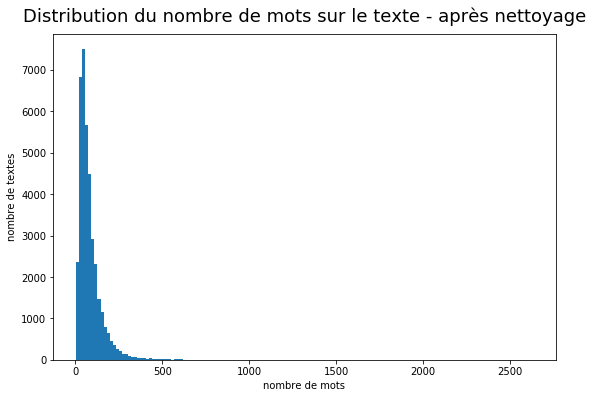

In [43]:
df['count'].plot(kind='hist', bins=150, figsize=(9, 6))
plt.xlabel('nombre de mots')
plt.ylabel('nombre de textes')
plt.title('Distribution du nombre de mots sur le texte - après nettoyage', y = 1.02, fontsize=18)
plt.show()

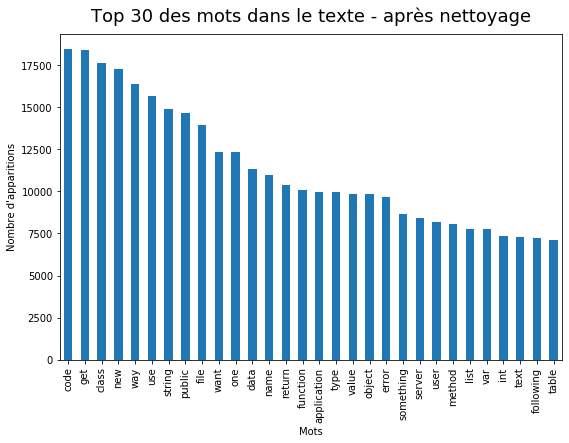

In [44]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['Text'], 30)
    
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='bar', figsize=(9, 6))
plt.xlabel('Mots')
plt.ylabel("Nombre d'apparitions")
plt.title('Top 30 des mots dans le texte - après nettoyage', y = 1.02, fontsize=18)
plt.show()

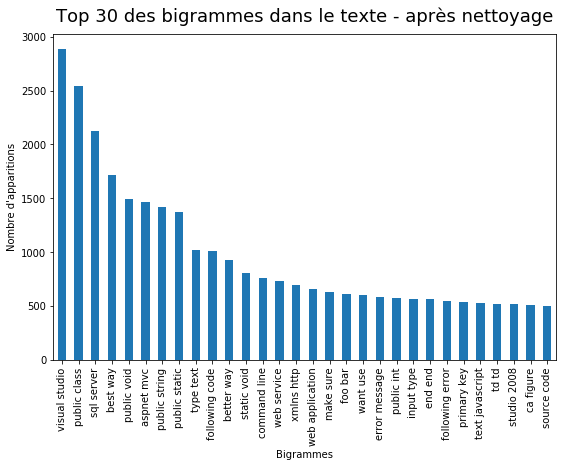

In [45]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Text'], 30)

df4 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
df4.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='bar', figsize=(9, 6))
plt.xlabel('Bigrammes')
plt.ylabel("Nombre d'apparitions")
plt.title('Top 30 des bigrammes dans le texte - après nettoyage', y = 1.02, fontsize=18)
plt.show()

## 5. Lemmatisation et Racinisation (stemming)

### 4.1 Lemmatisation

In [46]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['text_lemmatized'] = df["Text"].apply(lemmatize_text)

C:\Users\alice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 4.2 Stemming
Deux types de stemming seront effectués: porter, et lancaster. Le poids de leurs différences sera étudié plus tard dans les modèles.

In [47]:
def stemming_text_porter(text):
    return [porter.stem(w) for w in w_tokenizer.tokenize(text)]

df['text_stemm_porter'] = df["Text"].apply(stemming_text_porter)

C:\Users\alice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [48]:
def stemming_text_lancaster(text):
    return [lancaster.stem(w) for w in w_tokenizer.tokenize(text)]

df['text_stemm_lancaster'] = df["Text"].apply(stemming_text_lancaster)

C:\Users\alice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## 5. Dataset Final

### 5.1 Suppression des colonnes

In [49]:
#Je peux désormais supprimer les colonnes qui ne m'intéressent pas: title, body, count et tags
df = df.drop('Body', axis = 1).drop('Title', axis = 1).drop('count', axis = 1).drop('Tags', axis = 1)

In [50]:
df.head()

,Text,TagsTokens,text_lemmatized,text_stemm_porter,text_stemm_lancaster
0,c# 50 await keyword listed operator rather mod...,[c#],"[c#, 50, await, keyword, listed, operator, rat...","[c#, 50, await, keyword, list, oper, rather, m...","[c#, 50, await, keyword, list, op, rath, mod, ..."
1,configure mercurial use winmerge merges cygwin...,[mercurial],"[configure, mercurial, use, winmerge, merges, ...","[configur, mercuri, use, winmerg, merg, cygwin...","[config, merc, us, winmerg, merg, cygwin, merc..."
2,whats best way go photoshop mockup semantic ht...,"[html, css]","[whats, best, way, go, photoshop, mockup, sema...","[what, best, way, go, photoshop, mockup, seman...","[what, best, way, go, photoshop, mockup, sem, ..."
4,lookup data book barcode number building world...,[language-agnostic],"[lookup, data, book, barcode, number, building...","[lookup, data, book, barcod, number, build, wo...","[lookup, dat, book, barcod, numb, build, world..."
5,embeddable webkit component windows c# develop...,"[.net, com]","[embeddable, webkit, component, window, c#, de...","[embedd, webkit, compon, window, c#, develop, ...","[embed, webkit, compon, window, c#, develop, s..."


In [51]:
df.shape

(38393, 5)

In [52]:

export_csv = df.to_csv (r'C:\Users\alice\Desktop\DAAI\OC\P5_alice_barbotin\clean_dataframe_final.csv', index = None, header=True)